In [0]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [0]:
# Create a Spark session
spark = SparkSession.builder.appName("ChurnBinaryPrediction").getOrCreate()

In [0]:
df_spark_aggregated = spark.sql(
    """
WITH ranked_data AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY subscriptionitem__contact_rk, crm.produktnummer 
                           ORDER BY h.dbt_valid_from DESC) AS rn
    FROM
        prod.mart.abonnementsprodukter__historikk as h
    LEFT JOIN 
        prod.mart.crm_produkter AS crm 
    ON 
        h.subscriptionitem__dynamics_product_rk = crm.dynamics_product_rk
    LEFT JOIN
        prod.stage.stg_dynamics__contacts AS c
    ON 
        h.subscriptionitem__contact_rk = c.contact_rk
    LEFT JOIN prod.mart.geografi as g
    ON 
        c.contact__postalcode_rk = g.postalcode_rk
    WHERE
        (crm.produktnummer = 2010 OR crm.produktnummer = 2050) and NOT (h.innmeldingsdato is null and h.sluttdato is null and h.gyldig_til_dato is null)
),
aggregated_data AS (
    SELECT
        productusage__contact_rk,
        COUNT(*) AS produktuttak_count,
        CAST(SUM(`beløp`) AS INT) AS `total_beløp`
    FROM
        prod.mart.produktuttak
    WHERE
        status = "Utført"
    GROUP BY
        productusage__contact_rk
),
vehicle_data AS (
    SELECT
        ownerverification__contact_rk,
        COUNT(DISTINCT ownerverification_rk) AS n_vehic
    FROM
        prod.mart.eierverifiseringer__historikk
    WHERE
        status_kode_id IN (1, 2, 15)
    GROUP BY
        ownerverification__contact_rk
)
SELECT 
    r.contact_rk, 
    publikasjonsformat, 
    `avtale_antall_år`, 
    er_husstandsmedlem, 
    startdato, 
    sluttdato, 
    produktnummer, 
    age, 
    gender, 
    sentralitetsindex, 
    a.`total_beløp`,
    a.produktuttak_count,
    v.n_vehic
FROM 
    ranked_data r
LEFT JOIN
    aggregated_data a
ON
    r.contact_rk = a.productusage__contact_rk
LEFT JOIN
    vehicle_data v
ON 
    r.contact_rk = v.ownerverification__contact_rk
WHERE 
    rn = 1 
    """
)


In [0]:
# Convert to Pandas dataframe
df = df_spark_aggregated.toPandas()

In [0]:
len(df)

868655

In [0]:
df.head(20)

List `contact_rk` duplicates (if any)

In [0]:
duplicates = df[df["contact_rk"].duplicated(keep=False)]
no_duplicates = df[~df["contact_rk"].duplicated(keep=False)]

print(duplicates)

In [0]:
from datetime import datetime

def combine_rows_with_sum(group):
    # Extract rows for produktnummer 2010 and 2050
    row_2010 = group[group["produktnummer"] == "2010"].iloc[0].to_dict() if not group[group["produktnummer"] == "2010"].empty else {}
    row_2050 = group[group["produktnummer"] == "2050"].iloc[0].to_dict() if not group[group["produktnummer"] == "2050"].empty else {}

    # Use row_2010 as the base
    if row_2010 and row_2050:
        # Update startdato with the value from row_2050
        row_2010["startdato"] = row_2050.get("startdato", row_2010.get("startdato"))
        # Sum up avtale_antall_år values
        row_2010["avtale_antall_år"] = (
            float(row_2010.get("avtale_antall_år", 0)) + float(row_2050.get("avtale_antall_år", 0))
        )
    else:
        # If only row_2010 exists, retain its avtale_antall_år
        row_2010["avtale_antall_år"] = row_2010.get("avtale_antall_år", 0)
    
    return row_2010

# Apply the function and create a new DataFrame
combined_rows_with_columns = duplicates.groupby("contact_rk").apply(combine_rows_with_sum).tolist()

df = pd.concat([pd.DataFrame(combined_rows_with_columns), no_duplicates])
df["startdato"] = pd.to_datetime(df["startdato"], errors="coerce")
df["sluttdato"] = pd.to_datetime(df["sluttdato"], errors="coerce")
df = df[(df['sluttdato'].isna()) | (df['sluttdato'].dt.year <= datetime.now().year)]
df = df.drop(columns=["contact_rk"])

In [0]:
df.head(20)

Convert `sluttdato`=`null` to members with active membership, and `sluttdato`=`Date` to churner

In [0]:
df["churn"] = df["sluttdato"].notna()
df = df.drop(columns=["sluttdato", "startdato"])

# For total_beløp and item_count, replace null values with zero if a null indicates no transactions occurred.
df['total_beløp'] = df['total_beløp'].fillna(0)
df['produktuttak_count'] = df['produktuttak_count'].fillna(0)
df['n_vehic'] = df['n_vehic'].fillna(0)

In [0]:
len(df)

860564

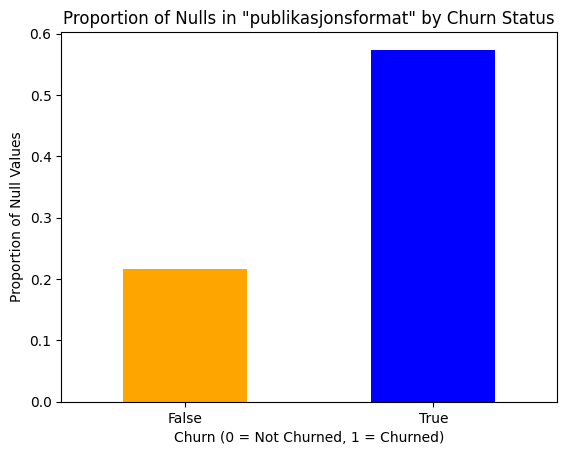

Overall proportion of nulls in publikasjonsformat: 36.98%


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'churn' and 'publikasjonsformat' columns
# 'churn' is 1 for churned users and 0 for active users

newdf = df.copy()
# 1. Create a summary of null and non-null values in publikasjonsformat
newdf['is_null_publikasjonsformat'] = newdf['publikasjonsformat'].isnull()

# Group by churn and check the proportion of nulls
churn_null_summary = newdf.groupby('churn')['is_null_publikasjonsformat'].mean()

# 2. Plot the proportion of nulls for churned and non-churned users
churn_null_summary.plot(kind='bar', color=['orange', 'blue'])
plt.title('Proportion of Nulls in "publikasjonsformat" by Churn Status')
plt.xlabel('Churn (0 = Not Churned, 1 = Churned)')
plt.ylabel('Proportion of Null Values')
plt.xticks(rotation=0)
plt.show()

# 3. Distribution of publikasjonsformat nulls across all data
overall_null_summary = newdf['is_null_publikasjonsformat'].mean()
print(f"Overall proportion of nulls in publikasjonsformat: {overall_null_summary:.2%}")

# 4. Provide insights and recommendations
# Drop it because it skews the data
del newdf
df = df.drop(columns=["publikasjonsformat"])


In [0]:
df.isnull().sum()

In [0]:
import pandas as pd
import numpy as np

# Assuming 'result' is your DataFrame

# Function to impute categorical columns by sampling based on existing distribution
def impute_categorical(df, columns):
    for col in columns:
        # Calculate the frequency of each category
        value_counts = df[col].value_counts(normalize=True)
        # Identify missing values
        mask = df[col].isna()
        n_missing = mask.sum()
        
        if n_missing > 0:
            # Sample values based on the distribution
            sampled_values = np.random.choice(
                value_counts.index,
                size=n_missing,
                p=value_counts.values
            )
            # Fill the missing values
            df.loc[mask, col] = sampled_values

# Function to impute numerical columns by sampling based on existing distribution
def impute_numerical(df, columns, add_noise=False, noise_range=(0, 0)):
    for col in columns:
        # Calculate the frequency of each unique value
        value_counts = df[col].value_counts(normalize=True)
        # Identify missing values
        mask = df[col].isna()
        n_missing = mask.sum()
        
        if n_missing > 0:
            # Sample values based on the distribution
            sampled_values = np.random.choice(
                value_counts.index,
                size=n_missing,
                p=value_counts.values
            )
            
            if add_noise:
                # Add random noise within the specified range
                noise = np.random.randint(noise_range[0], noise_range[1] + 1, size=n_missing)
                sampled_values = sampled_values + noise
            
            # Fill the missing values
            df.loc[mask, col] = sampled_values

# List of categorical columns
categorical_columns = ["gender", "avtale_antall_år", "sentralitetsindex"]

# List of numerical columns
numerical_columns = ["age"]

# Impute categorical columns
impute_categorical(df, categorical_columns)

# Impute numerical columns
# Option 1: Without adding noise
impute_numerical(df, numerical_columns)

# Option 2: With adding noise (e.g., +/- 5 years)
# impute_numerical(result, numerical_columns, add_noise=True, noise_range=(-5, 5))

All columns containing `null` (which will gets dropped)

In [0]:
df.isnull().sum()

In [0]:
df.dropna(inplace=True)
df = df[(df["age"] >= 16) & (df["age"] <= 95)]
df["age"] = df["age"].astype(int)
df = df[(df["avtale_antall_år"] <= df["age"] - 16) & (df["avtale_antall_år"] >= 0)]
df["avtale_antall_år"] = df["avtale_antall_år"].astype(int)
df = df[(df["n_vehic"] >= 0) & (df["n_vehic"] <= 30)]
df["n_vehic"] = df["n_vehic"].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


All unique column values

In [0]:
for col in df:
    print(df[col].unique())

Churner/Non-churner diff

In [0]:
df["churn"].value_counts()

False    488135
True     365933
Name: churn, dtype: int64

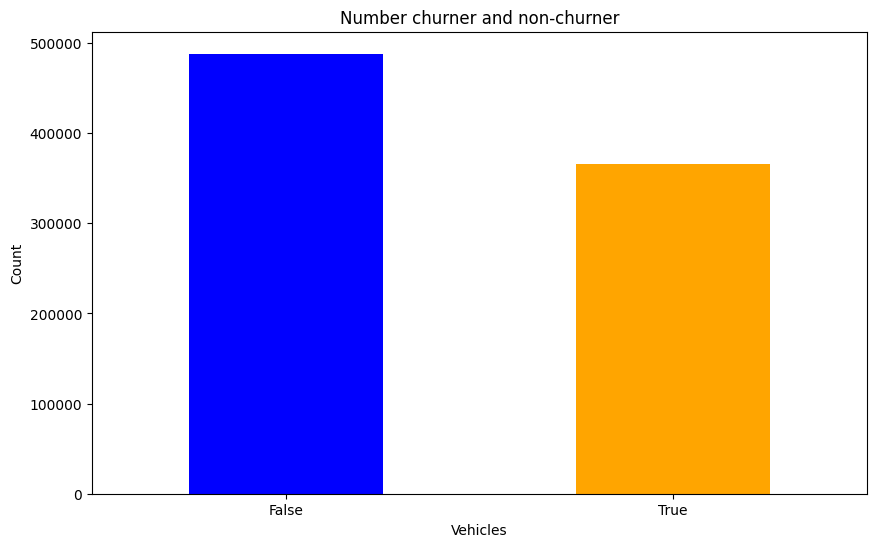

In [0]:
plt.figure(figsize=(10, 6))
df["churn"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Number churner and non-churner")
plt.xlabel("Vehicles")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

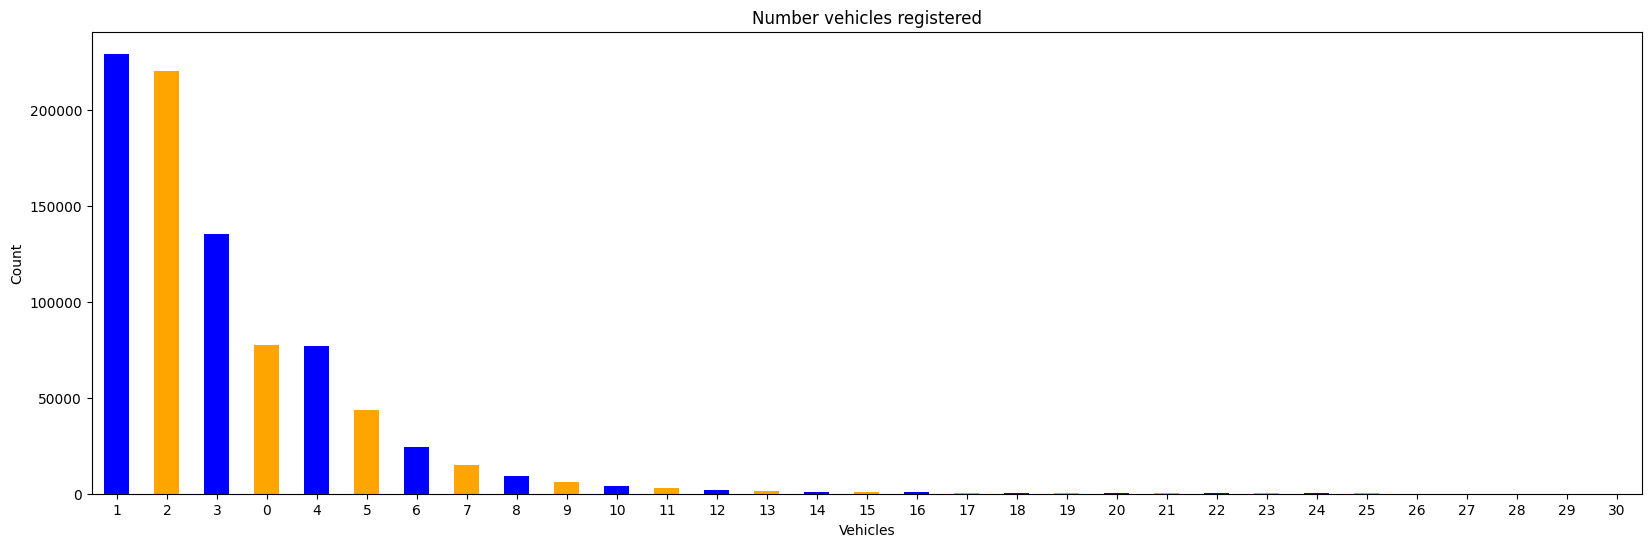

In [0]:
plt.figure(figsize=(20, 6))
df["n_vehic"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Number vehicles registered")
plt.xlabel("Vehicles")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

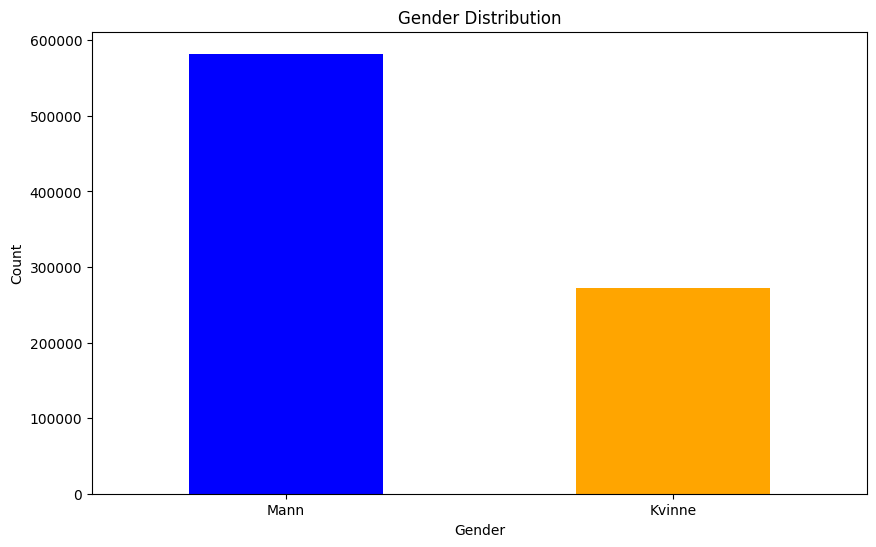

In [0]:
plt.figure(figsize=(10, 6))
df["gender"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

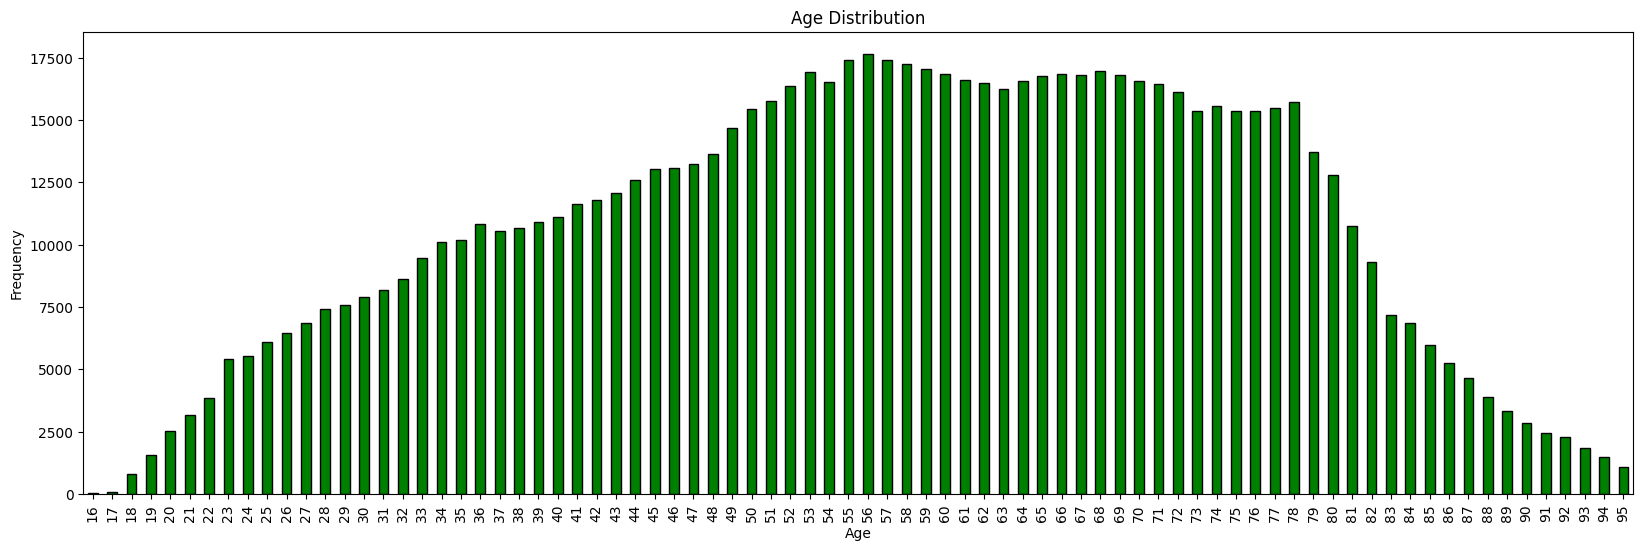

In [0]:
plt.figure(figsize=(20, 6))
df["age"].value_counts().sort_index().plot(kind="bar", color="green", edgecolor="black")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

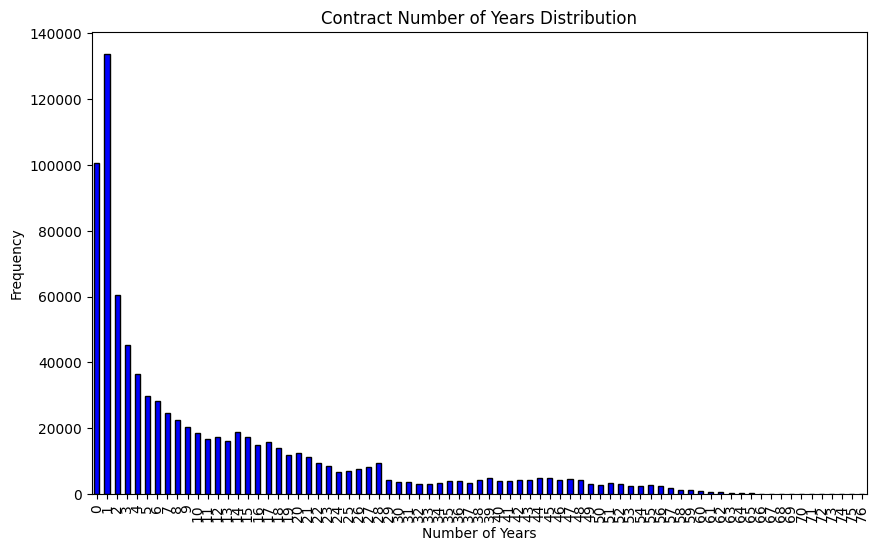

In [0]:
plt.figure(figsize=(10, 6))
df["avtale_antall_år"].value_counts().sort_index().plot(
    kind="bar", color="blue", edgecolor="black"
)
plt.title("Contract Number of Years Distribution")
plt.xlabel("Number of Years")
plt.ylabel("Frequency")
plt.show()

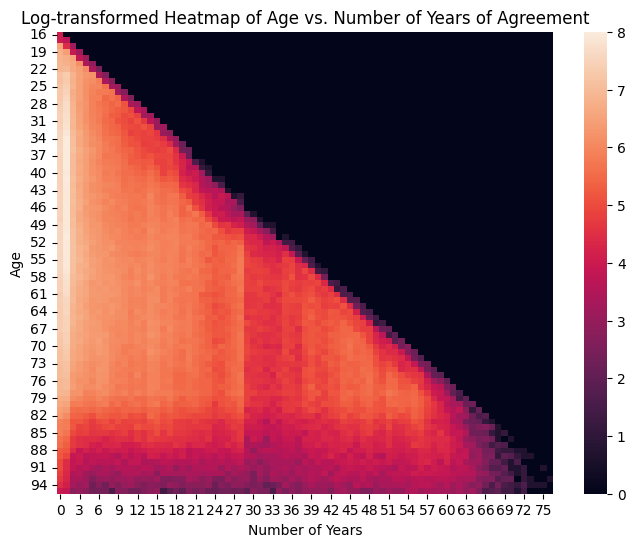

In [0]:
plt.figure(figsize=(8, 6))
heatmap_data = pd.crosstab(df["age"], df["avtale_antall_år"])
sns.heatmap(np.log1p(heatmap_data), cmap="rocket", annot=False, cbar=True)
plt.title("Log-transformed Heatmap of Age vs. Number of Years of Agreement")
plt.xlabel("Number of Years")
plt.ylabel("Age")
plt.show()

# Prediction

In [0]:
df_predict = df
df_predict["gender"] = df_predict["gender"].map({"Mann": 0, "Kvinne": 1})
df_predict["produktnummer"] = df_predict["produktnummer"].map({"2010": 0, "2050": 1})
df_predict["sentralitetsindex"] = df_predict["sentralitetsindex"].astype(int)
df_predict["total_beløp"] = df_predict["total_beløp"].astype(int)
df_predict["produktuttak_count"] = df_predict["produktuttak_count"].astype(int)
# df_predict["publikasjonsformat"] = df_predict["publikasjonsformat"].map({"Papir": 0, "Digital": 1})

In [0]:
df_predict.head()

,avtale_antall_år,er_husstandsmedlem,produktnummer,age,gender,sentralitetsindex,total_beløp,produktuttak_count,n_vehic,churn
0,10,False,0,29,0,848,1125,16,12,True
1,1,False,0,25,0,836,0,4,3,False
2,1,False,0,26,0,1000,0,2,2,True
3,9,False,0,26,0,800,0,4,9,False
4,1,False,0,69,0,890,0,1,2,False


In [0]:
for col in df_predict:
    print(df_predict[col].unique())

In [0]:
X = df_predict.drop(columns=["churn"])
y = df_predict["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, shuffle=True, stratify=y
)

In [0]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Trains the model, makes predictions, and evaluates performance.
    
    Parameters:
    - model: The machine learning model to train and evaluate
    - X_train: Training features
    - X_test: Testing features
    - y_train: Training target
    - y_test: Testing target
    
    Returns:
    - A dictionary containing evaluation metrics and confusion matrix
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )
    
    # Metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    auc_score = (
        roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    )
    
    # Display results
    print(f"Model: {model.__class__.__name__}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    if auc_score is not None:
        print(f"ROC AUC Score: {auc_score:.4f}")
    else:
        print("ROC AUC Score: Not applicable")


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define a list of models
models = {
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Extra Trees": ExtraTreesClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}

# Dictionary to store results
model_results = {}

# Evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    model_results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)



--- Evaluating CatBoost ---
Model: CatBoostClassifier
Confusion Matrix:
[[140187  30660]
 [ 38954  89123]]

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80    170847
        True       0.74      0.70      0.72    128077

    accuracy                           0.77    298924
   macro avg       0.76      0.76      0.76    298924
weighted avg       0.77      0.77      0.77    298924

ROC AUC Score: 0.8400

--- Evaluating Gradient Boosting ---
Model: GradientBoostingClassifier
Confusion Matrix:
[[137598  33249]
 [ 40680  87397]]

Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.81      0.79    170847
        True       0.72      0.68      0.70    128077

    accuracy                           0.75    298924
   macro avg       0.75      0.74      0.75    298924
weighted avg       0.75      0.75      0.75    298924

ROC AUC Score: 0.8217

--- Evaluating Ran

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Model: XGBClassifier
Confusion Matrix:
[[139557  31290]
 [ 39153  88924]]

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80    170847
        True       0.74      0.69      0.72    128077

    accuracy                           0.76    298924
   macro avg       0.76      0.76      0.76    298924
weighted avg       0.76      0.76      0.76    298924

ROC AUC Score: 0.8369

--- Evaluating AdaBoost ---
Model: AdaBoostClassifier
Confusion Matrix:
[[136890  33957]
 [ 46238  81839]]

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.80      0.77    170847
        True       0.71      0.64      0.67    128077

    accuracy                           0.73    298924
   macro avg       0.73      0.72      0.72    298924
weighted avg       0.73      0.73      0.73    298924

ROC AUC Score: 0.7966

--- Evaluating LightGBM ---
[LightGBM] [Info] Number of positive: 237

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Model: LGBMClassifier
Confusion Matrix:
[[139946  30901]
 [ 39586  88491]]

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80    170847
        True       0.74      0.69      0.72    128077

    accuracy                           0.76    298924
   macro avg       0.76      0.76      0.76    298924
weighted avg       0.76      0.76      0.76    298924

ROC AUC Score: 0.8357

--- Evaluating KNN ---
Model: KNeighborsClassifier
Confusion Matrix:
[[124893  45954]
 [ 48078  79999]]

Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.73      0.73    170847
        True       0.64      0.62      0.63    128077

    accuracy                           0.69    298924
   macro avg       0.68      0.68      0.68    298924
weighted avg       0.68      0.69      0.69    298924

ROC AUC Score: 0.7306
